# Машинное обучение - Лабораторная работа 3

**Выполнила:**  
Идрисова Лена  


### Импорт библиотек

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,  mean_squared_error, r2_score

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import gdown
from google.colab import drive

## Регрессия

### Загрузим датасет

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1Y7MM-B-QaSWuzgQxjt6iPvezZC3Zzjs8'
output = 'Advertising_new.csv'
gdown.download(url, output, quiet=False)
Advertising = pd.read_csv('/content/Advertising_new.csv')
Advertising.head()

Downloading...
From: https://drive.google.com/uc?export=download&id=1Y7MM-B-QaSWuzgQxjt6iPvezZC3Zzjs8
To: /content/Advertising_new.csv
100%|██████████| 14.8k/14.8k [00:00<00:00, 25.2MB/s]


,TV,radio,newspaper,sales
0,0.969852,0.981522,1.778945,1.552053
1,-1.197376,1.082808,0.669579,-0.696046
2,0.052050,1.217855,1.286405,0.860330
3,0.394182,-0.841614,1.281802,-0.215683
4,-1.045577,0.643905,-0.324708,-0.427043


### Разделим данные в файле Advertising на обучающие и проверочные данные, соотношение составляет 20%.

In [ ]:
X = Advertising.drop('sales', axis = 1)
y = Advertising['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

### Построение регрессора с различными вариантами архитектур

#### KNeighborsRegressor


предсказывает значение целевой переменной для новой точки данных на основе значений ближайших соседей в обучающем наборе данных

**Определение ближайших соседей:**

*   Для каждой новой точки данных алгоритм находит k ближайших соседей из обучающего набора данных
*   Близость определяется с помощью метрики расстояния

**Вычисление предсказания:**


*   Значение целевой переменной для новой точки данных вычисляется как взвешенное среднее значений целевой переменной для k ближайших соседей
*   Веса могут быть равномерными или обратно пропорциональными расстоянию до соседей

**Параметры KNeighborsRegressor**  


1.  **n_neighbors:** Количество ближайших соседей, используемых для определения предсказания.
2.   **weights:** Метод взвешивания соседей:

    *   'uniform': Все соседи имеют одинаковый вес. Это означает, что каждый сосед оказывает равное влияние на предсказание.
    *   'distance': Вес соседа обратно пропорционален его расстоянию до точки, для которой делается предсказание. Это означает, что ближайшие соседи будут иметь большее влияние на предсказание.

3.   **metric:** Метрика для вычисления расстояния между точками:

    *   'cityblock': Метрика городских кварталов (или манхэттенское расстояние). Это сумма абсолютных разностей по координатам.
    *   'euclidean': Евклидова метрика. Это квадратный корень из суммы квадратов разностей по координатам.
    *   'chebyshev': Метрика Чебышева. Это максимальная разность по координатам

#### Определяем сетку параметров для поиска лучшей модели регрессии. Используем GridSearchCV для поиска лучших параметров модели KNeighborsRegressor с помощью кросс-валидации

In [ ]:
# Определение параметров для поиска
param_grid = {
    'n_neighbors': [1, 3, 5],
    'weights': ['uniform', 'distance'],
    'metric': ['cityblock', 'euclidean', 'chebyshev']
}

# Создание модели регрессора
knr = KNeighborsRegressor()

# Поиск лучших параметров с помощью GridSearchCV
grid_search_reg = GridSearchCV(knr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['cityblock', 'euclidean', 'chebyshev'],
                         'n_neighbors': [1, 3, 5],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

GridSearchCV определил, что оптимальные параметры для модели KNeighborsRegressor:


*   n_neighbors=3: Позволяет модели учитывать ближайшие точки
*   weights='distance': Позволяет дальним соседям иметь меньшее влияние на предсказание, что может улучшить точность модели
*   metric='euclidean': Стандартная метрика, которая хорошо работает для большинства задач

Эти параметры были выбраны на основе кросс-валидации, что означает, что они дают наилучшие результаты на обучающей выборке и, вероятно, будут хорошо работать на тестовой выборке.

### Оценка качества регрессора



#### Mean Squared Error (MSE)



— это метрика, используемая для оценки качества модели регрессии. Она измеряет среднюю квадратичную ошибку между предсказанными значениями и фактическими значениями целевой переменной. Формула для вычисления MSE выглядит следующим образом:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

где:

- $n$ — количество наблюдений,
- $y_i$ — фактическое значение



#### Используем лучшую найденную модель регрессии для предсказания на тестовой выборке и вычисляем среднеквадратичную ошибку (MSE).

In [ ]:
# Оценка качества регрессора
best_regressor = grid_search_reg.best_estimator_
y_pred = best_regressor.predict(X_test)
mse = np.mean((y_test - y_pred) ** 2)
print(f'Mean Squared Error for Regressor: {mse}')

Mean Squared Error for Regressor: 0.04549676381806925


Для данного набора данных значение MSE равное 0.04549676381806925 можно считать хорошим результатом. Это означает, что модель в среднем ошибается на 0.21 единиц, что является относительно небольшой ошибкой по сравнению с диапазоном значений продаж.

## Классификация


### Загрузим датасет

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1bZinjn1gh3ZovYM2e6m_lwdkScYsooDG'
output = 'heart_new.csv'
gdown.download(url, output, quiet=False)
Heart = pd.read_csv('/content/heart_new.csv')
Heart.head()

Downloading...
From: https://drive.google.com/uc?export=download&id=1bZinjn1gh3ZovYM2e6m_lwdkScYsooDG
To: /content/heart_new.csv
100%|██████████| 7.55k/7.55k [00:00<00:00, 15.3MB/s]


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
1,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
2,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
3,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
4,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1


### Разделим данные в файле Heart на обучающие и проверочные данные, соотношение составляет 20%.

In [ ]:
X = Heart.drop('target', axis=1)
y = Heart['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Построение классификатора при одном наборе параметров


#### LogisticRegression

 — предсказывает вероятность принадлежности объекта к одному из двух классов (бинарная классификация) или к одному из нескольких классов (многоклассовая классификация).

**Основные принципы работы**

1. **Линейная комбинация признаков**:
   - Алгоритм строит линейную комбинацию признаков, умноженных на веса (коэффициенты).
   - Формула:  $ z = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_n x_n $, где $ \beta_i $ — веса, $ x_i $ — признаки.

2. **Логистическая функция (сигмоида)**:
   - Линейная комбинация признаков пропускается через логистическую функцию, которая преобразует её в вероятность.
   - Формула: $ \sigma(z) = \frac{1}{1 + e^{-z}} $, где $ \sigma(z) $ — вероятность принадлежности к классу 1.

3. **Пороговое значение**:
   - Если вероятность превышает определенный порог (обычно 0.5), объект классифицируется как принадлежащий к классу 1, иначе — к классу 0.

**Основные параметры**

1. **penalty**:
   - Тип регуляризации (штрафа), используемой для предотвращения переобучения.
   - `l2`: Регуляризация L2 (штраф за квадрат весов).
   - `l1`: Регуляризация L1 (штраф за абсолютные значения весов).
   - `elasticnet`: Комбинация L1 и L2 регуляризации.
   - `none`: Без регуляризации.

2. **C**:
   - Обратная величина регуляризации. Чем меньше значение, тем сильнее регуляризация.
   - Пример: `C=1.0` означает стандартное значение регуляризации.

3. **solver**:
   - Алгоритм оптимизации, используемый для нахождения весов.
   - `newton-cg`, `lbfgs`, `liblinear`, `sag`, `saga` — различные алгоритмы оптимизации.
   - Выбор алгоритма зависит от типа регуляризации и размера данных.

4. **max_iter**:
   - Максимальное количество итераций для сходимости алгоритма.
   - Пример: `max_iter=100` означает, что алгоритм будет выполнять до 100 итераций.

#### Создадим и обучим модель классификации LogisticRegression. Параметр max_iter=1000 указывает максимальное количество итераций для сходимости модели.

In [ ]:
# Создание и обучение модели классификатора
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### Оценка качества классификатора

Предскажем вероятности и классы для тестовой выборки и вычислим метрики качества: точность (accuracy), полнота (recall), точность (precision) и F1-score.

In [ ]:
# Предсказание вероятностей и классов
y_pred_proba = lr.predict_proba(X_test)[:, 1]
y_pred = lr.predict(X_test)

# Вычисление метрик качества
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

Accuracy: 0.8292682926829268
Precision: 0.9047619047619048
Recall: 0.7916666666666666
F1-score: 0.8444444444444444


**Accuracy** (точность - доля правильно классифицированных объектов от общего числа объектов.)показывает, что 82.93% объектов были классифицированы правильно. Это хороший показатель

**Precision** (точность -доля правильно классифицированных положительных объектов от общего числа объектов, классифицированных как положительные.) показывает, что из всех объектов, которые модель классифицировала как положительные, 90.48% действительно являются положительными. Это очень хороший показатель, указывающий на низкий уровень ложных срабатываний.

**Recall** (полнота - доля правильно классифицированных положительных объектов от общего числа действительно положительных объектов.) показывает, что модель обнаруживает 79.17% всех действительно положительных объектов. Это хороший показатель, но он немного ниже, чем точность, что указывает на наличие некоторых пропущенных положительных объектов.

**F1-score** (Гармоническое среднее между точностью и полнотой.) показывает баланс между точностью и полнотой. Значение 0.8444 указывает на хорошее качество модели, учитывая оба аспекта.

### ROC-кривая


1. **ROC-кривая**:
   - ROC-кривая строится путем сравнения двух показателей: **True Positive Rate (TPR)** и **False Positive Rate (FPR)** при различных порогах классификации.
   - **TPR (True Positive Rate)**, также известный как **Recall** или **Sensitivity**, показывает долю правильно классифицированных положительных объектов от общего числа действительно положительных объектов.
   - **FPR (False Positive Rate)** показывает долю неправильно классифицированных отрицательных объектов от общего числа действительно отрицательных объектов.
   - ROC-кривая показывает, как изменяется TPR по отношению к FPR при изменении порога классификации.

2. **AUC (Area Under the Curve)**:
   - AUC представляет собой площадь под ROC-кривой.
   - Значение AUC варьируется от 0 до 1. Чем ближе значение AUC к 1, тем лучше модель различает положительные и отрицательные классы.
   - AUC = 0.5 указывает на случайную модель, которая не имеет способности различать классы.
   - AUC = 1 указывает на идеальную модель, которая безошибочно различает классы.



Построим ROC-кривую для модели классификации и вычисляем площадь под кривой (AUC).

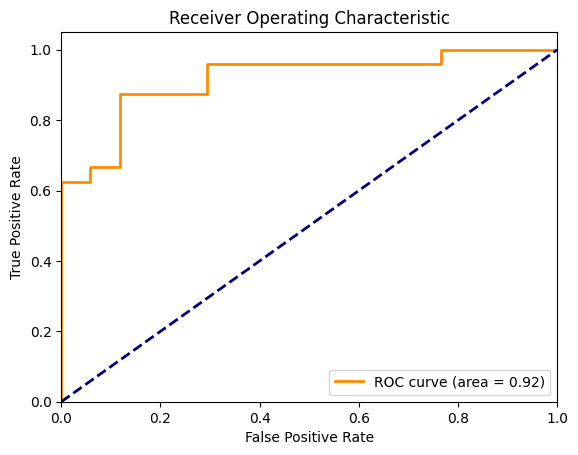

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**ROC-кривая** (оранжевая линия) показывает, как изменяется TPR по отношению к FPR при различных порогах классификации.

Кривая начинается с точки (0, 0) и заканчивается в точке (1, 1), что указывает на то, что модель способна различать классы.

Кривая имеет резкие изменения, что может указывать на наличие дискретных значений вероятностей в предсказаниях модели.

**AUC:** AUC равно 0.92.

Это очень хороший показатель, указывающий на то, что модель имеет высокую способность различать положительные и отрицательные классы.

Значение AUC = 0.92 говорит о том, что с вероятностью 92% модель правильно ранжирует случайные положительные и отрицательные объекты.

### Оценка качества классификации при различных пороговых значениях

Вычислим метрики качества классификации при различных пороговых значениях

In [ ]:
thresholds = np.linspace(0, 1, 100)
metrics = []
for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_threshold)
    precision = precision_score(y_test, y_pred_threshold)
    recall = recall_score(y_test, y_pred_threshold)
    f1 = f1_score(y_test, y_pred_threshold)
    metrics.append([threshold, accuracy, precision, recall, f1])

metrics_df = pd.DataFrame(metrics, columns=['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
print(metrics_df)

    Threshold  Accuracy  Precision    Recall  F1-score
0    0.000000  0.585366   0.585366  1.000000  0.738462
1    0.010101  0.634146   0.615385  1.000000  0.761905
2    0.020202  0.682927   0.648649  1.000000  0.786885
3    0.030303  0.682927   0.657143  0.958333  0.779661
4    0.040404  0.682927   0.657143  0.958333  0.779661
..        ...       ...        ...       ...       ...
95   0.959596  0.439024   1.000000  0.041667  0.080000
96   0.969697  0.439024   1.000000  0.041667  0.080000
97   0.979798  0.439024   1.000000  0.041667  0.080000
98   0.989899  0.414634   0.000000  0.000000  0.000000
99   1.000000  0.414634   0.000000  0.000000  0.000000

[100 rows x 5 columns]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Метрики показывают, что модель имеет различные характеристики при разных порогах классификации.

При низких порогах модель имеет высокую полноту, но низкую точность.

При высоких порогах модель имеет высокую точность, но низкую полноту.

Оптимальный порог можно выбрать на основе баланса между точностью и полнотой, который отражается в F1-score.

### Определение оптимального значения порога классификации на основе анализа F1-score

In [ ]:
optimal_threshold = metrics_df.loc[metrics_df['F1-score'].idxmax(), 'Threshold']
print(f'Optimal Threshold: {optimal_threshold}')

Optimal Threshold: 0.43434343434343436


### **Вывод**
В ходе выполнения лабораторной работы были построены и оценены модели регрессии и классификации на основе алгоритмов k-ближайших соседей (KNeighborsRegressor) и логистической регрессии (LogisticRegression) соответственно. Далее приведены основные шаги, результаты и выводы по каждой части работы.